In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#hide
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal, uniform, choice, randint
from numpy import pi
import sys, shutil
from tqdm import tqdm
from deeptrack.disp import *
from deeptrack.simg import *
from deeptrack.fastai_adapter import *
from deeptrack.measures import radialcenter
from deeptrack.models import DeepTrackNet
from deeptrack.video import track_single_particle

from fastai.vision import *
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Demonstrating single particle position extraction performance
> An experiment to train DeepTrackTorch to extract position of a particle from image containing a single particle.

## Introduction

This notebook aims to demonstrate the validity of the implementation of deeptrack by replicating the first experiment outline in the [original paper](https://www.osapublishing.org/optica/abstract.cfm?uri=optica-6-4-506) where the position of a single particle in a still image is predicted. The position predicted by the deep learning network is compared to more traditional particle detection techniques (radial symmetry method).

We then go on to test the performance of slightly different versions of the network, which have been modified with the aim of better detecting particles in video in mind:
 - a version where the single particle training images that also contain examples with no particles
 - a version where the training images contain multiple particles. The network must predict the most central particle.

## 1. Single particle position

### Training set

Following from the [example notebook - 1a](https://github.com/softmatterlab/DeepTrack/blob/master/DeepTrack%201.0/DeepTrack%20-%20Example%201a%20-%20Tracking%20single%20particle.ipynb) the particle position is chosen randomly from a normal distribution with mean of 0 and standard deviation of 1 pixel. The particle has a radius between 1.5 and 3 pixels, and a point-spread function obtained from Bessel function of the first kind of first or second order with positive or negative intensity. The image background, SNR and gradient intensity are randomly selected from a wide range of values. There is one and only one particle per image in this test.

These parameters are expressed as follows:

In [ ]:
base_img_params = {   
      'n_particles': lambda: 1,
      'size': lambda: 51,
      'bkgd_level': lambda: uniform(0.2,0.8),
      'gradient_intensity': lambda: uniform(0,0.8),
      'gradient_direction': lambda: uniform(-pi,pi),
      'snr': lambda: uniform(5,100),
  }

base_particle_params = {
      'x': lambda: normal(0,0.1), #these are not in units of pixels
      'y': lambda: normal(0,0.1),
      'radius': lambda: uniform(1.5, 3),
      'intensities': lambda: [uniform(.7, .9, 1), -uniform(.2, .3, 1)],
      'bessel_orders': lambda: [1, 2]    ,
      'ellip_direction': lambda: uniform(-pi, pi),
      'ellipticity':  lambda: 1,
  }

The training was carried out on a [colab](https://colab.research.google.com/drive/1EcLXHPFqn3l0vKiY2t9TvaTwFwB7ed6C) notebook but the following demonstrates sample training images.

In [ ]:
import cProfile
import re
cProfile.run('define_image(base_img_params, base_particle_params, 10000)', 'restats')

import pstats
p = pstats.Stats('restats')
p.strip_dirs().sort_stats(-1).print_stats()



Mon Jun 15 10:56:22 2020    restats

         612179 function calls (612163 primitive calls) in 2.134 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        7    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(copyto)
       11    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1017(_handle_fromlist)
    10000    0.009    0.000    0.194    0.000 <ipython-input-3-691c45857f31>:11(<lambda>)
    10000    0.007    0.000    0.118    0.000 <ipython-input-3-691c45857f31>:12(<lambda>)
    10000    0.010    0.000    0.045    0.000 <ipython-input-3-691c45857f31>:13(<lambda>)
    10000    0.174    0.000    1.213    0.000 <ipython-input-3-691c45857f31>:14(<lambda>)
    10000    0.005    0.000    0.005    0.000 <ipython-input-3-691c45857f31>:15(<lambda>)
    10000    0.014    0.000    0.053    0.000 <ipython-input-3-691c45857f31>:16(<lambda>)
    10000    0.003    0.000    0.003    0.000 <ipython-input-

[None, None, None, None, None]

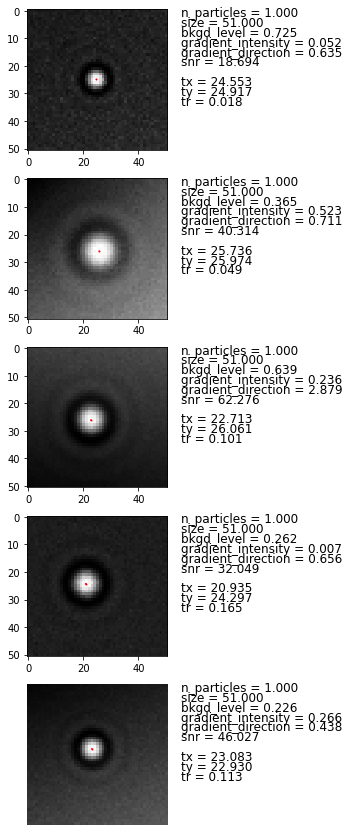

In [ ]:
train_specs_df = add_target(define_image(base_img_params, base_particle_params, 5), mode='r')
f,ax=plt.subplots(5,1,figsize=(5,15))
[annotate_image(generate_image(i_s),i_s,ax=ax[i]) for (i,i_s) in train_specs_df.iterrows()]

### Load Pre-trained model

This model was trained using 100k images generated using the above parameter distributions. (Note DeepTrack using 1.5 million training images)

In [ ]:
learner = load_learner('models/100k/r_1p_close')

### Create test dataset

Create a dataset that we feed to the network to get it's inferences. Use the same parameters used to create the training images

In [ ]:
test_img_dist = base_img_params.copy()
test_p_dist = base_particle_params.copy()
test_img_dist['gradient_intensity']=lambda : 0

### Measure performance vs Radial Symmetry method for varying levels of SNR

Now loop through SNR values and evaluate predictions, record results

In [ ]:
#notest
MAE_snr_dtt=[]
MAE_snr_sym=[]

for snr in np.logspace(np.log10(3),np.log10(80), num=15):
    # fix the snr
    test_img_dist['snr'] = lambda : snr
    # produce 1000 images at this SNR
    test_df = define_image(test_img_dist, test_p_dist, 10)
    
    test_df = add_target(test_df)
    test_images = MImageList.from_df(test_df)
    test_truth = test_df[['tx','ty','tr']].to_numpy()
    
    # try depptracktorch
    dtt_preds = np.array([learner.predict(x)[1].numpy() for x in test_images])
    
    # try symterical
    sym_preds = np.array([radialcenter(x.px.squeeze())[:3] for x in test_images])
    MAE_snr_dtt += [[snr, mean_absolute_error(test_truth, dtt_preds)]]
    MAE_snr_sym += [[snr, mean_absolute_error(test_truth, sym_preds)]]


import pickle
with open('snr_results.pkl','wb') as f:
    pickle.dump((MAE_snr_dtt,MAE_snr_sym),f)
   

In [ ]:
MAE_snr_dtt

[[3.0, 1.9341748346512322],
 [3.7929416720912945, 2.1402890130498147],
 [4.795468842628902, 2.2576207763987814],
 [6.062977870140858, 1.9938424606846148],
 [7.665507140208194, 2.0703315523310306],
 [9.691607156603009, 1.7596464829233252],
 [12.253233551272587, 1.5729154897675572],
 [15.491933384829666, 2.2592925156907513],
 [19.58666657219426, 2.434797591824703],
 [24.763694619677725, 2.415415834482491],
 [31.309083092639543, 2.2161100138531857],
 [39.584508659013835, 1.8370365459406859],
 [50.047244154010734, 2.240097408717932],
 [63.27542597502492, 1.6865923393000937],
 [79.99999999999999, 2.3151824863894657]]

### Performance for varying background gradient intensities

Set up experimental parameters

In [ ]:
test_img_dist = base_img_params
test_p_dist = base_particle_params

test_img_dist['snr'] = lambda: 50

Now loop through gradient intensity values and evaluate predictions, record results

In [ ]:
#notest
MAE_gi_dtt=[]
MAE_gi_sym=[]

for gi in np.linspace(0,1, num=11):
    # fix the gradient
    test_img_dist['gradient_intensity'] = lambda : gi
    
    # produce 1000 images at this SNR
    test_df = define_image(test_img_dist, test_p_dist, 100)
    test_df = add_target(test_df)
    
    test_images = MImageList.from_df(test_df)
    test_truth = test_df[['tx','ty','tr']].to_numpy()
    
    # try depptracktorch
    dtt_preds = np.array([learner.predict(x)[1].numpy() for x in test_images])
    
    # try symterical
    sym_preds = np.array([radialcenter(x.px.squeeze())[:3] for x in test_images])
    
    MAE_gi_dtt += [[gi, mean_absolute_error(test_truth, dtt_preds)]]
    MAE_gi_sym += [[gi, mean_absolute_error(test_truth, sym_preds)]]



In [ ]:
import pickle
with open('gi_results.pkl','wb') as f:
    pickle.dump((MAE_gi_dtt,MAE_gi_sym),f)

### Plot results

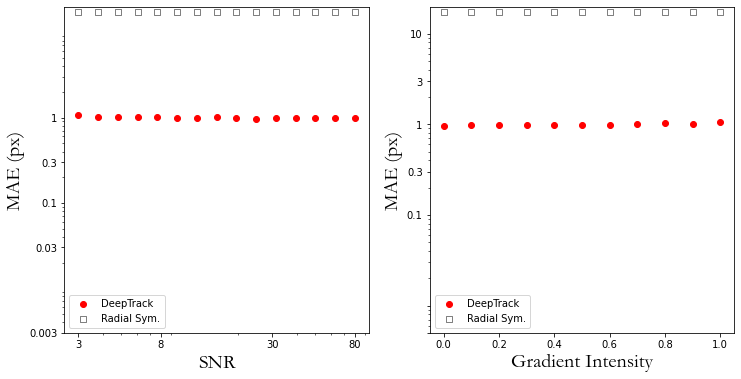

In [ ]:
#notest
with open('snr_results.pkl','rb') as f:
    Md_snr,Ms_snr = pickle.load(f)

with open('gi_results.pkl','rb') as f:
    Md_gi,Ms_gi = pickle.load(f)

fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].scatter(x=np.array(Md_snr)[:,0],y=np.array(Md_snr)[:,1],label='DeepTrack',marker='o',c='r')
ax[0].scatter(x=np.array(Ms_snr)[:,0],y=np.array(Ms_snr)[:,1],label='Radial Sym.',marker='s',ec='grey',fc='none')
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xticks([3,8,30,80])
ax[0].set_xticklabels([3,8,30,80])
ax[0].set_yticks([0.003,0.03,0.1,0.3,1])
ax[0].set_yticklabels([0.003,0.03,0.1,0.3,1])
ax[0].set_xlabel('SNR', fontsize=20, fontfamily='Garamond')
ax[0].set_ylabel('MAE (px)', fontsize=20,fontfamily='Garamond')
ax[0].legend()

# Gradient Intensity Plot
ax[1].scatter(x=np.array(Md_gi)[:,0],y=np.array(Md_gi)[:,1],label='DeepTrack',marker='o',c='r')
ax[1].scatter(x=np.array(Ms_gi)[:,0],y=np.array(Ms_gi)[:,1],label='Radial Sym.',marker='s',ec='grey',fc='none')
ax[1].set_yscale('log')
ax[1].set_yticks([0.005,0.01,0.1,0.3,1,3,10])
ax[1].set_yticklabels(['','',0.1,0.3,1,3,10])
ax[1].set_xlabel('Gradient Intensity', fontsize=20,fontfamily='Garamond')
ax[1].set_ylabel('MAE (px)', fontsize=20,fontfamily='Garamond')
ax[1].legend()

In [ ]:
#notest
# take the predicted positions and compare to symtry method
video_file_name = '../../DeepTrack 1.0/DeepTrack - Example 2 - Optically Trapped Particle Bad.mp4'

estimators = {
        'deeptrack':lambda image: learner.predict(npimg2tensor(image))[1].numpy(),
        'symmetry':lambda image: np.array(radialcenter(image)[:3],dtype=np.float32),
    }

predicted_positions = track_single_particle(
    video_file_name, 
    estimators,use_cv2=False)

ImportError: cannot import name 'npimg2tensor' from 'deeptrack.simg' (/Users/wooduk/projects/deeptracktorch/nbs/deeptrack/simg.py)

In [ ]:
#notest
plt.plot(predicted_positions['deeptrack'][:,1])
plt.plot(predicted_positions['symmetry'][:,1])
